In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from utils import DataAnalyzer

In [2]:
train_path = '../data/train_cleaned.csv'
test_path = '../data/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()
train_df = train_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
test_df = test_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

train_df.head()

,survived,passenger_class,name,gender,age,sibling_spouse_count,parent_child_count,ticket,ticket_fare,cabin,embarked_from,age_range,family_size,cabin_group,winsorized_fare
0,0,third,"braund, mr. owen harris",male,22.0,1,0,a/5 21171,7.2500,NaN,southampton,20-29,1,NaN,7.2500
1,1,first,"cumings, mrs. john bradley (florence briggs th...",female,38.0,1,0,pc 17599,71.2833,c85,cherbourg,30-39,1,c,71.2833
2,1,third,"heikkinen, miss. laina",female,26.0,0,0,ston/o2. 3101282,7.9250,NaN,southampton,20-29,0,NaN,7.9250
3,1,first,"futrelle, mrs. jacques heath (lily may peel)",female,35.0,1,0,113803,53.1000,c123,southampton,30-39,1,c,53.1000
4,0,third,"allen, mr. william henry",male,35.0,0,0,373450,8.0500,NaN,southampton,30-39,0,NaN,8.0500


### Feature Selection

- Drop irrelavant columns 

In [3]:
df = train_df.drop(['name', 'ticket', 'cabin', 'sibling_spouse_count', 'parent_child_count', 'ticket_fare', 'age_range'], axis=1)

- handle missing data 

In [4]:
DataAnalyzer.get_missing_values(df)

,Total Nulos,% Nulos
cabin_group,687,77.104377
age,177,19.865320
embarked_from,2,0.224467


- Drop the cabin_group column as 77.10% of the data is missing, and imputing missing values might introduce noise.
- For the age column, fill the missing values with the median age (approximately 29.70 years) based on the age distribution observed during exploratory data analysis.
- For the embarked_port column, fill the two missing values with the mode (the most common port) as it provides a reasonable estimate given the limited number of missing entries.

In [5]:
df.drop(['cabin_group'], axis=1, inplace=True)
df['embarked_from'].fillna(df['embarked_from'].mode()[0], inplace=True)
df['age'].fillna(df['age'].median(), inplace=True)

### Feature Engineering 

- Age Category: Bins the ages into 'Child', 'Teenager', 'Young Adult', 'Adult', and 'Elderly' groups for more generalized analysis.

In [6]:
age_bins = [0, 12, 18, 30, 50, 100]
age_labels = ['child', 'teenager', 'young adult', 'adult', 'elderly']
df['age_category'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)


- Fare per Family Member: Calculates normalized fare value for each family member based on family size.

In [7]:
df['fare_per_family_member'] = df['winsorized_fare'] / (df['family_size'] + 1)  

In [8]:
## Drop age column as age_category is calculated 
df.drop(['age'], axis=1, inplace=True)

In [9]:
DataAnalyzer.get_missing_values(df)

,Total Nulos,% Nulos


In [10]:
df.head()

,survived,passenger_class,gender,embarked_from,family_size,winsorized_fare,age_category,fare_per_family_member
0,0,third,male,southampton,1,7.2500,young adult,3.62500
1,1,first,female,cherbourg,1,71.2833,adult,35.64165
2,1,third,female,southampton,0,7.9250,young adult,7.92500
3,1,first,female,southampton,1,53.1000,adult,26.55000
4,0,third,male,southampton,0,8.0500,adult,8.05000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   survived                891 non-null    int64   
 1   passenger_class         891 non-null    object  
 2   gender                  891 non-null    object  
 3   embarked_from           891 non-null    object  
 4   family_size             891 non-null    int64   
 5   winsorized_fare         891 non-null    float64 
 6   age_category            891 non-null    category
 7   fare_per_family_member  891 non-null    float64 
dtypes: category(1), float64(2), int64(2), object(3)
memory usage: 49.9+ KB


### Separate Target 

In [12]:
X = df.drop('survived', axis=1)
y = df['survived']

### Train-Test Split

- The data will be split in a 80/20 proportion. 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
class_distribution = y_train.value_counts()

# Calculate the ratio of survived vs. non-survived
survived_ratio = class_distribution[1] / len(y_train)
non_survived_ratio = class_distribution[0] / len(y_train)

print(f'Survived Ratio: {survived_ratio}')
print(f'Non-Survived Ratio: {non_survived_ratio}')

Survived Ratio: 0.37640449438202245
Non-Survived Ratio: 0.6235955056179775


In [15]:
print("Categorical feature distributions:")
print(X_train['gender'].value_counts())
print(X_train['passenger_class'].value_counts())
print(X_train['embarked_from'].value_counts())
print(X_train['age_category'].value_counts())

print("Categorical feature distributions:")
print(X_test['gender'].value_counts())
print(X_test['passenger_class'].value_counts())
print(X_test['embarked_from'].value_counts())
print(X_test['age_category'].value_counts())

Categorical feature distributions:
male      467
female    245
Name: gender, dtype: int64
third     398
first     163
second    151
Name: passenger_class, dtype: int64
southampton    527
cherbourg      125
queenstown      60
Name: embarked_from, dtype: int64
young adult    360
adult          201
elderly         60
child           57
teenager        34
Name: age_category, dtype: int64
Categorical feature distributions:
male      110
female     69
Name: gender, dtype: int64
third     93
first     53
second    33
Name: passenger_class, dtype: int64
southampton    119
cherbourg       43
queenstown      17
Name: embarked_from, dtype: int64
young adult    88
adult          55
elderly        14
child          11
teenager       11
Name: age_category, dtype: int64


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

### Data Transformation

In [17]:


numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])


### Build the XGBoost Model

In [19]:
xgb_clf_v1 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

pipeline_v1 = Pipeline([
    ('preprocess', preprocessor),  
    ('classifier', xgb_clf_v1)  
])

pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['family_size', 'winsorized_fare', 'fare_per_family_member'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['passenger_class', 'gender', 'embarked_from', 'age_category'], dtype='object'...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])

In [20]:
pipeline_v1.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns)

array(['passenger_class_first', 'passenger_class_second',
       'passenger_class_third', 'gender_female', 'gender_male',
       'embarked_from_cherbourg', 'embarked_from_queenstown',
       'embarked_from_southampton', 'age_category_adult',
       'age_category_child', 'age_category_elderly',
       'age_category_teenager', 'age_category_young adult'], dtype=object)

### Predictions and Model Baseline Evaluation

In [21]:
y_pred_v1 = pipeline_v1.predict(X_test)

In [22]:
from metrics import ClassificationPlots

plots = ClassificationPlots()
classification_report_str = plots.get_classification_report(y_test, y_pred_v1)
print(classification_report_str)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       105
           1       0.82      0.82      0.82        74

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



### Hyperparameter tunning

In [23]:
xgb_clf_v2 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

pipeline_v2 = Pipeline([
    ('preprocess', preprocessor),  
    ('classifier', xgb_clf_v2) 
])

neg_to_pos_ratio = class_distribution[0] / class_distribution[1]

param_grid = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'classifier__max_depth': [3, 5, 7],  
    'classifier__n_estimators': [50, 100, 150],  
    'classifier__scale_pos_weight': [neg_to_pos_ratio] # As there is a disbalanced in the target Survived Ratio: 0.37640449438202245 and Non-Survived Ratio: 0.6235955056179775
}

grid_search = GridSearchCV(
    estimator=pipeline_v2,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=5,  
    n_jobs=-1,  
)

grid_search.fit(X_train, y_train) 

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [24]:
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

### Metrics

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       105
           1       0.83      0.84      0.83        74

    accuracy                           0.86       179
   macro avg       0.86      0.86      0.86       179
weighted avg       0.86      0.86      0.86       179



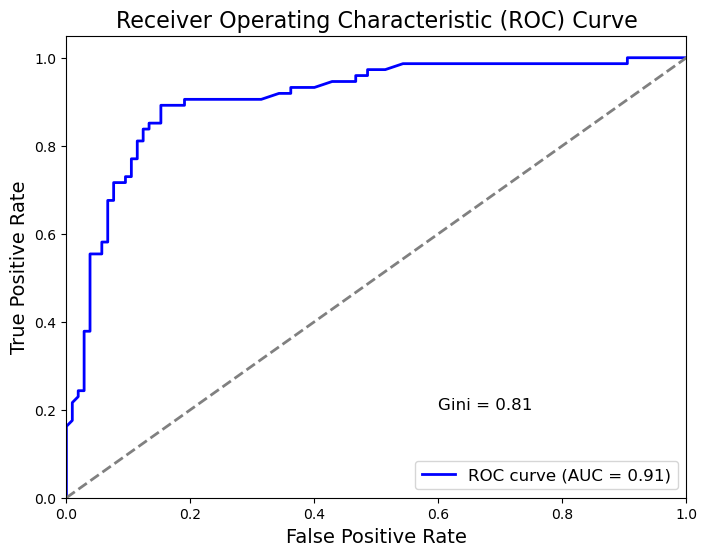

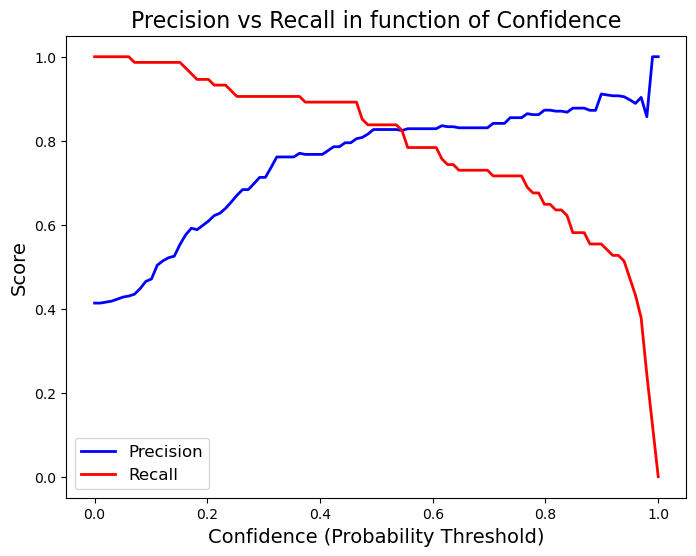

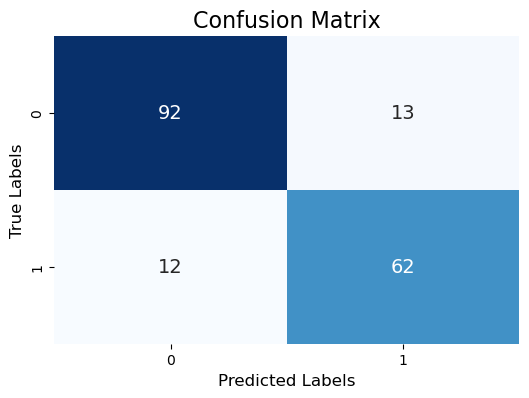

In [25]:
cr = plots.get_classification_report(y_test, y_pred)
print(cr)
plots.plot_roc_curve(y_test, y_pred_prob)
plots.plot_precision_and_recall(y_test, y_pred_prob)
plots.plot_confusion_matrix(y_test, y_pred)

### Confusion Matrix 
- Positive Class (Class 1): Survived passengers (encoded as 1)
- Negative Class (Class 0): Non-Survived passengers (encoded as 0)

- True Positive (TP): 62 passengers correctly predicted as survivors.
- False Positive (FP): 12 passengers falsely predicted as non-survivors.
- True Negative (TN): 93 passengers correctly predicted as non-survivors.
- False Negative (FN): 12 passengers falsely predicted as survivors.

### Save Final Model and  Data Transformer

In [26]:
import pickle
import joblib

with open('../api/model/survival_predictor.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [27]:
## Save the transformation to apply to other datasets in order to keep consistency in the data and being able to reproduce among other reasons. 
joblib.dump(pipeline_v2.named_steps['preprocess'].named_transformers_['num'].named_steps['scaler'], '../api/model/minmax_scaler.pkl')
joblib.dump(pipeline_v2.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'], '../api/model/onehot.pkl')

['../api/model/onehot.pkl']